# **EDSA Movie Recommendation 2022**

© Explore Data Science Academy

---
### Honour Code

We **Team CW6** , confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### MOVIE RECOMMENDER SYSTEM 2022

![image.png](attachment:image.png)

In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

A movie recommender system is basically a tool that helps streaming media platforms recommend users’ favorite movies on the basis of their interests and behavior. It creates a list of favorite movies according to the user profile. Using an AI-based algorithm that analyzes the data, it goes through various possible options, and creates a customized list of items that are interesting and relevant to an individual.

Our company has been awarded the contract to:

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of Analysing the recommendations;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.


Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project, the team is tasked to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences..
Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.




<a id="cont"></a>

## **Table of Contents**

<a href=#one>1. Comet</a>

<a href=#two>2. Importing Libraries</a>

<a href=#three>3. Loading Dataset</a>

<a href=#four>4. Data Preprocessing</a>

<a href=#five>5. Eploratory Data Analysis (EDA)</a>

<a href=#six>6. Feature Engineering and Selection</a>

<a href=#seven>7. Model Selection</a>

<a href=#eight>8. Model Evaluation</a>

<a href=#nine>9. References</a>

<a id="one"></a>
## 1. **Comet**
---
    
| ⚡ Description: Comet ⚡ |
| :--------------------------- |
| In this section will section we will import the comet experiment from comet.ml and decribe what comet is.
---

Comet.ml is a Machine Learning experimentation platform which AI researchers and data scientists use to track, compare and explain their ML experiments. It allows ML practitioners to keep track of their databases, history of performed experiments, code modifications and production models. It enables model reproduction, easy maintenance of ML workflow and smooth collaboration throughout the iterative process of ML lifecycle. It also performs model optimization using Bayesian hyperparameter optimization algorithm and thereby reduces the overhead of tuning your model manually.

In [10]:
#from comet_ml import Experiment

# Create an experiment with your api key
#experiment = Experiment(
#    api_key="9PHva3TLb6iKcFaLO30pADfXK",
 #   project_name="movie-reccomender-edsa",
  #  workspace="caiphus24",
#)

<a id="two"></a>
# **2. Importing Libraries**


---
    
| ⚡ Description:  Libraries ⚡ |
| :--------------------------- |
| In this section will section we will import libraries machine leaning we will use in this notebook.

In [5]:
# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from datetime import datetime
# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 37)
import warnings
warnings.filterwarnings('ignore')

# Style
import matplotlib.style as style 

style.use('seaborn-pastel')

from PIL import Image


'''Algos'''
import lightgbm as lgb
'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy



<a id="three"></a>
# 3. **Importing Dataset**

---
    
| ⚡ Description:  Dataset ⚡ |
| :--------------------------- |
| In this section are to load the data from the `train`, `test`, `tags`, `movies`, `links`, `imdb_data`, `genome_tags` and `genome_scores` files into  DataFrames. |
---

We are to load all the data we will be working with throughout our project.

In [82]:
# Importing the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv', index_col='movieId')
links = pd.read_csv('links.csv')
imdb_data = pd.read_csv('imdb_data.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv', index_col='movieId')
rating_df = pd.read_csv('ratings.csv')

The all the data will be used for the analysis modeling in this project and the test data will be used for Kaggle submission for leaderboard score.

<a id="four"></a>
## 4. Data Preprocessing
<a class="anchor" id="1.1"></a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are going to create new features - as identified in the EDA phase. |

---

Data preprocessing is the process where we engineer our data like changing data types, romoving nulls values, doing feature selection ect. This part of data preprocessing is very important because the perfomance of our algorithms will depend mostly fro our data preprocessing meaning data that is not proper proprocessed may lead to great impact in our model performance, like scaling we know that our data varies in different units with different mean values so we have to scale our data so that it is under the same units.

1. **Movie Overview**

In [18]:
movies.head(5)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:

print("Movie Information")
movies.info()
print('-----------------------------------')
print('-----------------------------------')
print('-----------------------------------')
print("Missing Values")
movies.isnull().sum()

Movie Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
-----------------------------------
-----------------------------------
-----------------------------------
Missing Values


movieId    0
title      0
genres     0
dtype: int64

The movie data has Three columns and 63422 entries in total, they are no missing and null values in the dataset

**Train Overview**


In [20]:
train.head(5)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [27]:
print("Movie Information")
train.info()
print('-----------------------------------')
print('-----------------------------------')
print('-----------------------------------')
print("Missing Values")
train.isnull().sum()

Movie Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
-----------------------------------
-----------------------------------
-----------------------------------
Missing Values


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

The train data has 4 column and 10000038 entries in total.They are no missing data in all column which makes it easier for us to work with the data 

Let us merge both the train data and the movie data before we begin with our analysis

**IMDB Overview**

In [53]:
imdb_data.head(5)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [54]:
print("Movie Information")
imdb_data.info()
print('-----------------------------------')
print('-----------------------------------')
print('-----------------------------------')
print("Missing Values")
imdb_data.isnull().sum()

Movie Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
-----------------------------------
-----------------------------------
-----------------------------------
Missing Values


movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

The IMDB has a 6 folders and a total of 27278. This data consist of missing values for title_cast, Director, Runtime,Bugdet and Plot_keyword columns, it will be difficult working with this data

In [ ]:
# Merging the train and movies data on the movieId column
train = train.merge(movies, on='movieId')

Merging both the data sets will make things a lot easier and  helps us get the insight we need to understand the kind of data we have.



As we can see that the timestamp column is a bit messed up in a way, we need to convert the time stamp to date time. In this project,we will only use the year to help us understand our data better.

In [29]:
# Convert timestamp to year column representing the year the rating was made on merged dataframe
train['rating_year'] = train['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).year)
train.drop('timestamp', axis=1, inplace=True)

The time stamp is our for our ratings, the ratings that took place in a year, we created a new cloumn for the year ratings

Creating movie release year by extracting the year from the title

In [30]:
def get_release_dates(title):
    #getting the 4 last values on the data
    sub = title[-5:-1]
    #Initializing the input to integer data type
    year = int(sub) if sub.isdigit() else 9999   
    #Return the year
    return year

In [31]:
# Creating the release year by extracting the release year from the movie title
train['release_year'] = train['title'].apply(get_release_dates)

In [32]:
# Checking number of distinct years for movie releases, including the ealrliest and most recent year
train['release_year'].nunique(), train['release_year'].min(), train['release_year'].max()

(136, 6, 9999)

6 and 9999 cannot be years, we need to exlude them from our data moving forward

In [33]:
train[train['release_year'] != 6]['release_year'].min(), train[train['release_year'] != 9999]['release_year'].max()

(1874, 2019)

Now our data is fixed,we can see that our data shows that the last movie that was released on the year 2019 and the first movie was released in the year 1874

<a id="five"></a>
## 5. Exploratary Data Analysis
<a class="anchor" id="1.1"></a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, we are to make sense of the data by using visuals and explaining what the data does. |

---

Exploratory Aata Analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

First let us check our release movie data

## **Movie Release**

In [36]:
def get_releases_by_year(df, release_years):
    #Grouping the release year 
    mask = df[(df['release_year'] >= release_years[0]) & (df['release_year'] <= release_years[-1])]
    return [mask[mask['release_year'] == year]['movieId'].nunique() for year in release_years]

**Overall Movies Released per Year**

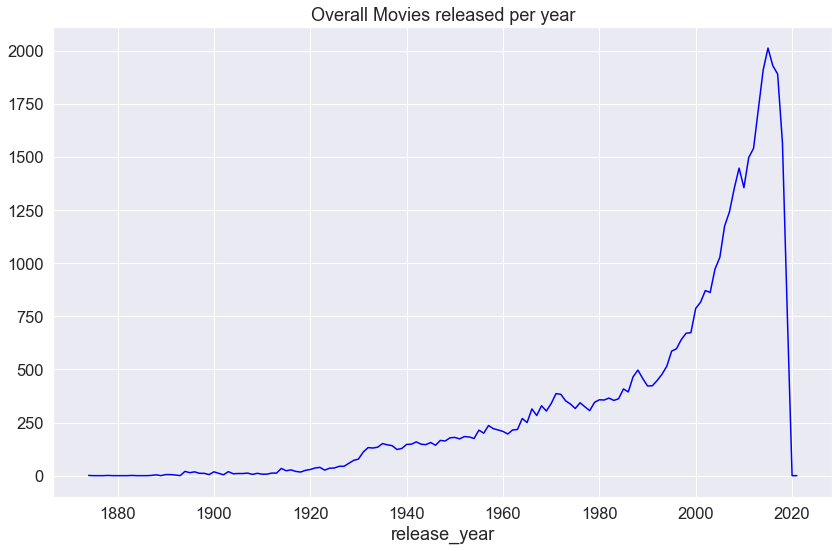

In [37]:
overall_movies = pd.DataFrame({'release_year': list(range(1874, 2022)),
                                      'count': get_releases_by_year(train, range(1874, 2022))})
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

ax1 = overall_movies.groupby('release_year')['count'].sum().plot(kind='line', ax=ax, title='Overall Movies released per year', color = 'blue')


fig.tight_layout()


from 1880 to 1995 based of the above graph, we can asssume that from pre 1880 to 1995 the total movies that were released per year are below the 500 in total, which we might not conisder when checking ratings of movies per year. The data is not sufficient to work with, but before that we will check the data of movies pre 1995 and post 1995 to really make sure of our assumption.

**Movies released before 1995**

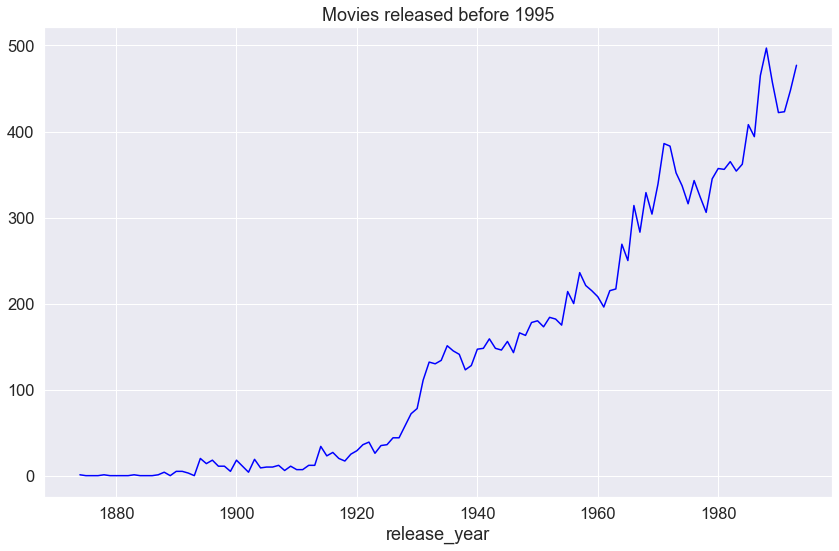

In [39]:
pre_95_releases = pd.DataFrame({'release_year': list(range(1874, 1994)),
                                       'count': get_releases_by_year(train, range(1874, 1994))})


fig, ax = plt.subplots(1, 1, figsize = (12, 8))

ax1 = pre_95_releases.groupby('release_year')['count'].sum().plot(kind='line', ax=ax, color = 'blue', title='Movies released before 1995')


fig.tight_layout()

The above graphs shows us that our previous assumption was indeed correct, we have under a total of 500 movies per year released pre 1995, We think the reason might have been that less people had access to TVs which made the production companies to really not invest more in movies, techonology was not that advanced before like it is now, only certain type of people where able to have access to TV's, the market was not competative.

In [40]:
# Check for the number of movies released between 1995 and 2019
train[(train['release_year'] >= 1874) & (train['release_year'] <= 1994)]['movieId'].nunique()

17936

We have a total of 1736 movies released pre 1995

**Movies Released after 1995**

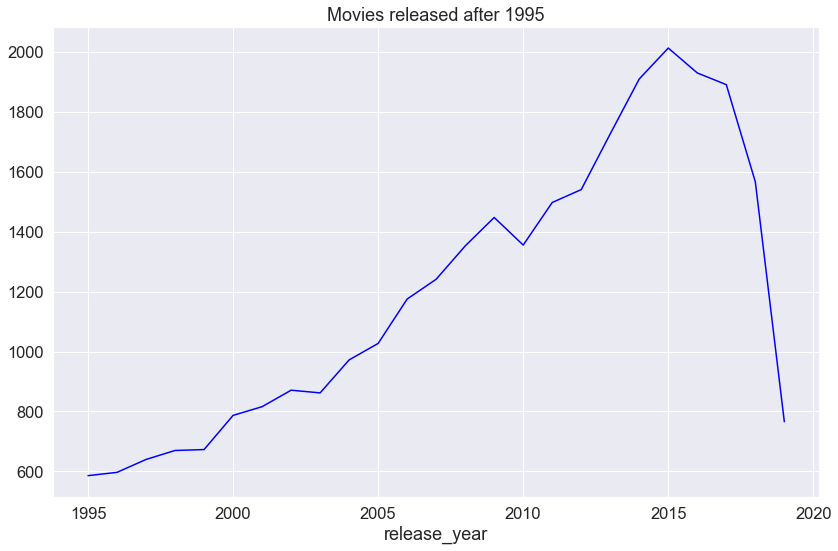

In [16]:
post_94_releases = pd.DataFrame({'release_year': list(range(1995, 2020)),
                                       'count': get_releases_by_year(train, range(1995, 2020))})

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

ax1 = post_94_releases.groupby('release_year')['count'].sum().plot(kind='line', ax=ax, title='Movies released after 1995', color = 'blue')


fig.tight_layout()

The above graph shows us that movie production companies start to increase their production rate for movies, there is a rapid increase of movies per year. That may be because technology waas advancing and more people owned TVs and other sort of alternatives to watch movies. We can see that there was a slide decrease of movie production between 2008 to 2010, we may assume that teh production rate may have been affected by by the 2010 world cup which shifted the focus of many when it came to preparations. The data from post 1995 will really be helpful and useful to visualisations of movie ratings and ratings per year.

In [42]:
# Check for the number of movies released between 1995 and 2019
train[(train['release_year'] >= 1995) & (train['release_year'] <= 2019)]['movieId'].nunique()

29906

The total movies released post 1995 are 29906, which is a huge increase in production pre 1995. This might be beacuse of how techonology is advancing and peole get to stream movies from different platforms, which increases the demand in movie production,

## **Genre**

**Popular Movie Genres**

In [45]:
def feature_frequency(df, column):
    """
    Function to count the number of occurences of metadata such as genre
    Parameters
    ----------
        df (DataFrame): input DataFrame containing movie metadata
        column (str): target column to extract features from
    Returns
    -------

    """
    # Creat a dict to store values and drop nan values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                  'count': list(), }
    # Retrieve a list of all possible genres
    for movie in range(len(df)):
        # Splitting the genres
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)

        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    data = data.sort_values(by='count', ascending=False)

    return data


genres = feature_frequency(movies, 'genres')


Text(0.5, 0, 'Number of Movies')

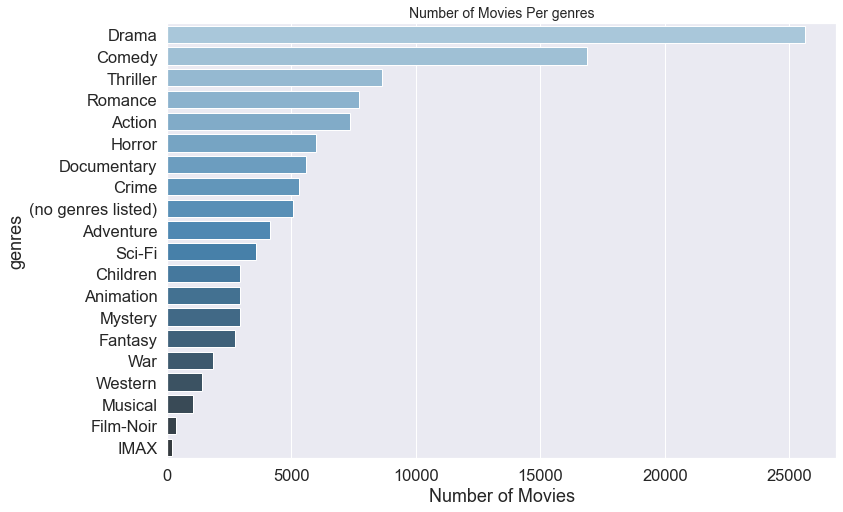

In [46]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y=genres['genres'], x=genres['count'], palette=("Blues_d"), orient='h')
plt.title('Number of Movies Per genres', fontsize=14)
plt.ylabel('genres')
plt.xlabel('Number of Movies')

The above graph shows that genre drama appears in most movies, which makes us believe that it might be because Drama delivers the emotional and relational development of realistic characters in a realistic setting. It offers intense character development and tells an honest story of human struggle, which most people can relate to and is why it has so many movies under this genre. It is followed by Comedy, as there is a say that says laughter is best medicine to human kind.

<span style='color:blue'> Given the genres and which genre appears the movies in every move genre, let us take a look at the top actors and directors involved in all movies using the based on the imdb data</span>

**Total Movies per Actor**

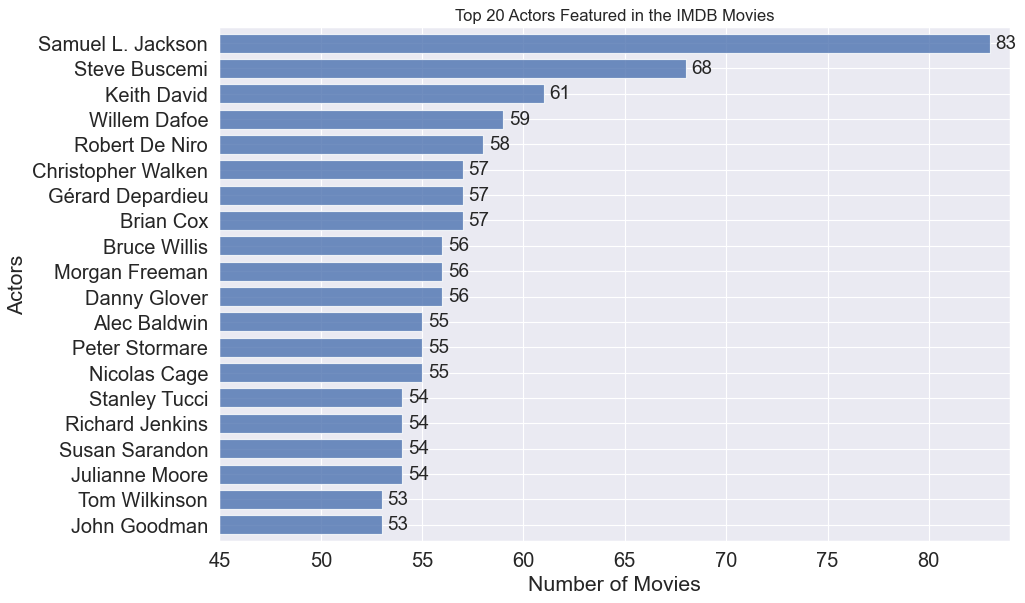

In [48]:
movies_actor = pd.DataFrame(imdb_data[['movieId', 'title_cast']], columns=['movieId', 'title_cast'])
# Split title_cast seperated by "|" and create a list containing the title_cast allocated to each movie
movies_actor = movies_actor[movies_actor['title_cast'].notnull()]
movies_actor.title_cast = movies_actor.title_cast.apply(lambda x: x.split('|'))
# Create expanded dataframe where each movie-tite_cast combination is in a seperate row
movies_actor = pd.DataFrame([(tup.movieId, d) for tup in movies_actor.itertuples() for d in tup.title_cast], columns=['movieId', 'title_cast'])
movies_actor = movies_actor.groupby(['title_cast'])['movieId'].count().reset_index(name='Number of Movies')
movies_actor = movies_actor.sort_values(by='Number of Movies', ascending=False)
# Sececting the Top 20 actors in movies
movies_actor = movies_actor .head(20)
movies_actor = movies_actor.sort_values(by='Number of Movies', ascending=True)
y_labels = movies_actor['title_cast']

# Plot the figure.
fig = plt.figure(figsize=(12, 8), dpi=85)
ax = movies_actor['Number of Movies'].plot(kind='barh', color='b', fontsize=17, xlim=[45, 84], width=.75, alpha=0.8)
ax.set_title('Top 20 Actors Featured in the IMDB Movies', fontsize=14)
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actors')
ax.set_yticklabels(y_labels)
rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), fontsize=16,textcoords="offset points", va='center', ha=ha)

The actor that has been in the industry according to the above graph we can see that it is Samuel L.Jackson, we was featured in a total on 83 top rated movies on imdb. This tell how good the actors is and how industries believed in his talent, followed by Steve Buscemi with total movies 68 featured in.

**Top 20 Directors featured in top rated movies IMDB**

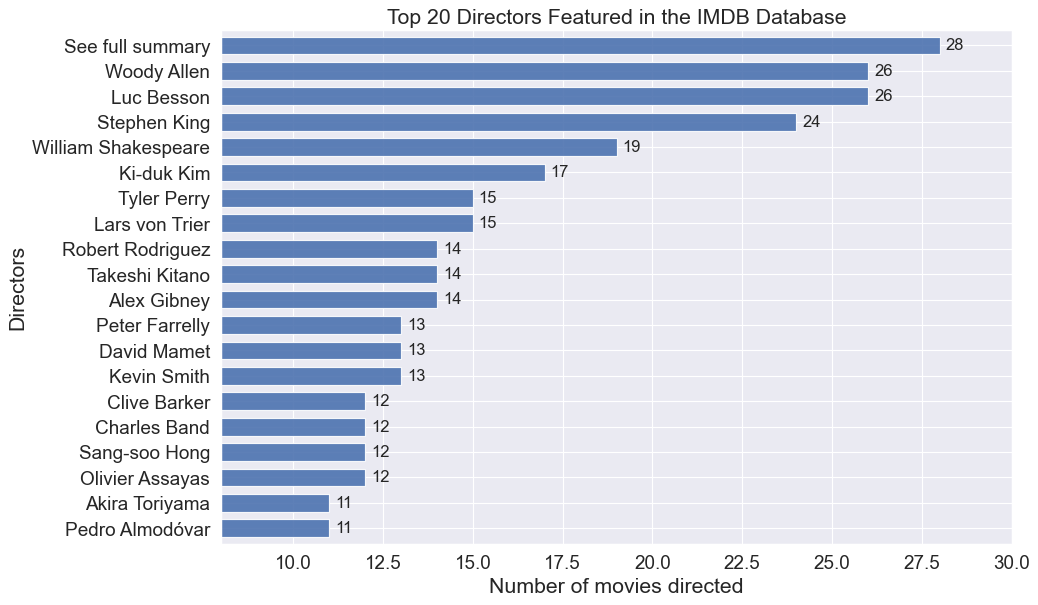

In [49]:
movies_director = pd.DataFrame(imdb_data[['movieId', 'director']], columns=['movieId', 'director'])
movies_director = movies_director.groupby(['director'])['movieId'].count().reset_index(name="count")
movies_director = movies_director.sort_values(by='count', ascending=False)
movies_director = movies_director .head(20)
movies_director = movies_director.sort_values(by='count', ascending=True)
y_labels = movies_director['director']

# Plot the figure.
plt.figure(figsize=(12, 8), dpi=85)
ax = movies_director['count'].plot(kind='barh', color='b', width=.7, fontsize=16, xlim=[8, 30], alpha=0.9)
ax.set_title('Top 20 Directors Featured in the IMDB Database', fontsize=18)
ax.set_xlabel('Number of movies directed')
ax.set_ylabel('Directors')
ax.set_yticklabels(y_labels)

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{}".format(x_value)

    # Create annotation
    plt.annotate(label, (x_value, y_value), xytext=(
        space, 0), textcoords="offset points", va='center', ha=ha, fontsize=14)

According to the above graph, it shows that see all summary is the most director, directing a total of 28 top movies in imdb. The analysis might be wrong by setting see all summary as a director. We can assume that Woody Allen and Luc Besson are the most highly rated directors who directed a total of top 26 imdb movies each.

<span style='color:red'>As stated in our data preprocessing, the two above graphs using the imdb data might not be consistant as they are missing values, we cannot sorely depend on the above graph to make any conlusions or analysis</span>

## Ratings

**Total ratings by year**

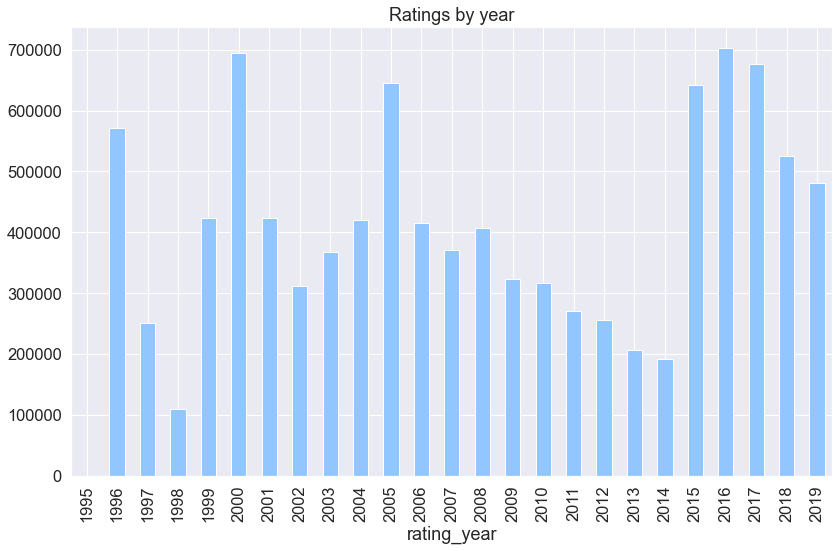

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax1 = train.groupby('rating_year')['rating'].count().plot(kind='bar', title='Ratings by year')
fig.tight_layout()

The year 2000 and 2016 had the higest total movie rating scores compared to all the other years, like the always 2000s are the problem, we believe that is when the techonoly advanced and people had their chance of expressing how the feel regarding to certain, also again we can assume that it was when they relased the top movies which resulted in higher rating score, the ratings are ranged from 1-5, wwhich makes 5 to be the most top movie and 1 the worst or most disliked movie when rating. We will then look at the ratings to get a better understanding our our ratings movie data.

**User Ratings**

Text(0, 0.5, 'Number of Ratings')

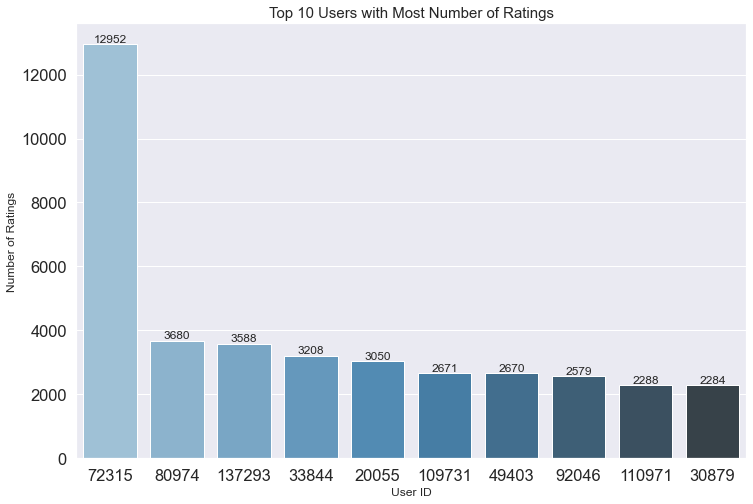

In [56]:
# create figure with white grid style
plt.figure(figsize=(12,8))

# use user id data from train df
# plot barplot
data = train['userId'].value_counts(ascending=False).head(10)
fig = sns.barplot(x=data.index, y=data, order=data.index, palette='Blues_d')

for p in fig.patches:
        fig.text(p.get_x() + p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

# add title and label
plt.title("Top 10 Users with Most Number of Ratings", size=15)
plt.xlabel("User ID", size=12)
plt.ylabel("Number of Ratings", size=12)

* User ID 72315 has more ratings compared to other users, the ratings of more than 12000, the second, third, fourth and number five on the plot above has ratings from 3050 - 3680, which is not even half of the first user. the sixth to number ten has 2000 ratings. this shows that users do rate movies. 

In this case, we will exlude user 72315 from our analysis going forward since we are not sure if the user is indeed a person or a bot/robot.The huge margin to order users does not make sense at all.

In [57]:
#Excluding user 72315
eda_df = train[train['userId']!=72315]

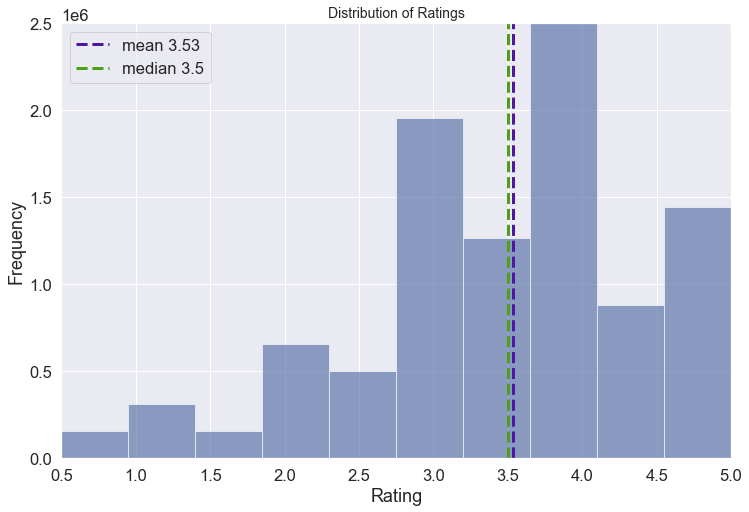

In [61]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        column (str): column to plot
    Returns
    -------
        distplot (NoneType): distplot of rating frequencies
    """
    plt.figure(figsize=(12,8))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#4863A0")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

ratings_distplot(eda_df)

It is interesting that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. Instead, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it

<span style='color:light'>Now let as look at the ratings between the underrated and best rated movies, underrated movies will be based on ratings less than the median and best movies will be based on movies greater than the mean. The mean and median are shown on the above graph</span>

In [75]:
def plot_ratings(count, n=10, color='#4DA017', best=True, method='mean'):
    """
    docstring
    """
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(train.join(
            movies, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(train.join(
            movies, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = train.groupby(
        'movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count'] > count]
    data.sort_values('rating', inplace=True, ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title = 'Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title = 'Worst Rated'
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=plot['rating'], y=plot['title'],
                    size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('', fontsize=8)
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=14)
    plt.tight_layout()
    plt.show()


**Top rated movies**\
With an ratings of greater than 3.5 per rating

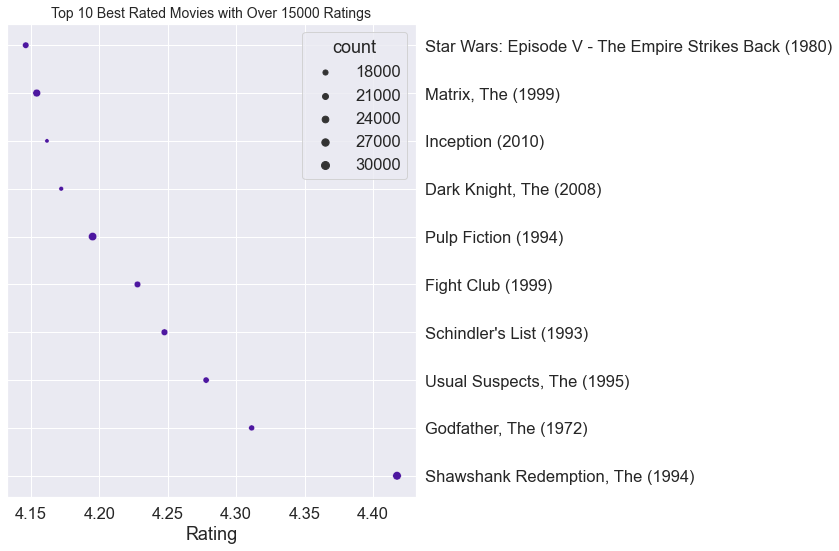

In [76]:
plot_ratings(count=15000, n=10, color='#4D17A0', best=True, method='mean')

The star Wars Episode V released in 1980 seem to be the most like movie, followed by the Matrix released in 1999. The seem to be that the most rated movies where released in pre 1994 and the above rating graph does not sure an analysis of pre 1995 ratings. can it be that users have a preference of older movies?

**Underrated Movies**

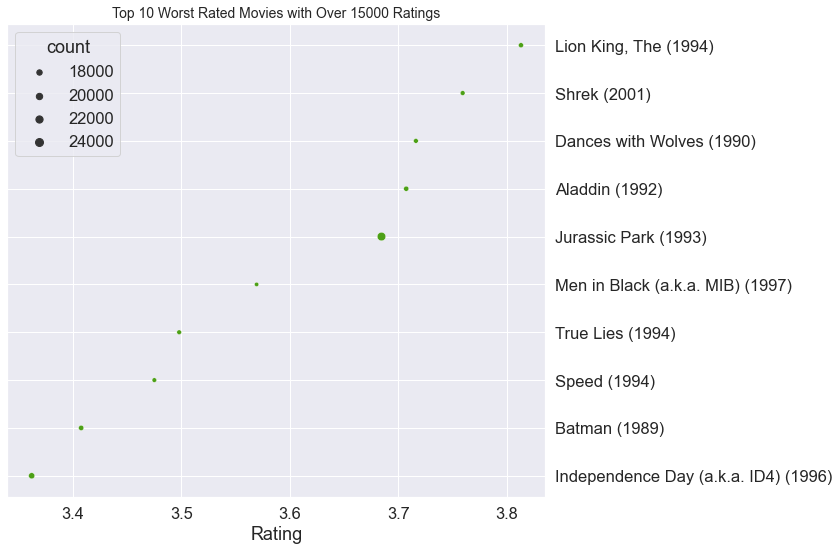

In [79]:
plot_ratings(count=15000, n=10, color='#4DA017',best=False, method='mean')

The above graphs shows us the most underrated movies of all time which received a rated of below 3.5 per users and most of the movies are movies released pre 1995

<a id="six"></a>
## 6. Feature Engineering and Selection
<a class="anchor" id="1.1"></a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

# Feature Engineering

### Multidimensional Scaling
Multidimensional scaling (MDS) is a technique for visualizing distances between objects on a map, where the distance is known between pairs of the objects.  
> "The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate."

In [32]:
# Subset the data to cut down computation time 
genome_score = genome_scores[:10000000]

In [33]:
# Scaling the genome_score using a standard scaling
scaler = StandardScaler()
genome = scaler.fit_transform(genome_score.sample(frac=0.0001))

In [34]:
#minimizing the Kullback–Leibler divergence
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)
#fitting genome score
tsne.fit(genome)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.010s...
[t-SNE] Computed neighbors for 1000 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.065484
[t-SNE] Computed conditional probabilities in 0.012s
[t-SNE] Iteration 50: error = 84.5797195, gradient norm = 0.0000241 (50 iterations in 0.268s)
[t-SNE] Iteration 100: error = 84.5797195, gradient norm = 0.0000036 (50 iterations in 0.200s)
[t-SNE] Iteration 150: error = 84.5797195, gradient norm = 0.0000042 (50 iterations in 0.186s)
[t-SNE] Iteration 200: error = 84.5797195, gradient norm = 0.0000088 (50 iterations in 0.177s)
[t-SNE] Iteration 250: error = 84.5797195, gradient norm = 0.0000248 (50 iterations in 0.176s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.579720
[t-SNE] Iteration 300: error = 4.5634131, gradient norm = 0.0000404 (50 iterations in 0.167s)
[t-SNE] Iteration 350: error = 4.5634112, gradient norm = 0.00011

TSNE(learning_rate=0.1, n_components=3, n_jobs=-1, perplexity=10, verbose=2)

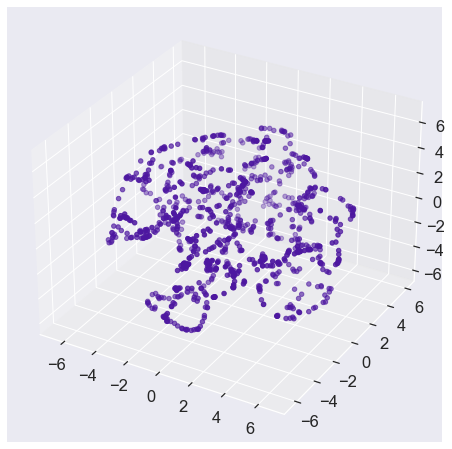

In [35]:
#Displaying the genome score using 3D
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='#4D17A0')
plt.show()

### Principal Component Analysis
Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

Due to the large data that we are working with, we now need to create a function to help us with pivot table. Pivot table can be be done automatically but due to the large data, that is why we need to create one manually.

In [36]:


genome_scores.head(2)

,tagId,relevance
movieId,,
1,1,0.02875
1,2,0.02375


In [37]:
# Creating a funtion  for pivot table manually due to large amount of data
def pivot_(df):
    """
    Pivots table.
    """
    new_dict = {'movieId':sorted(set(df.index))}
    pivoted = pd.DataFrame(new_dict)
    tagids = sorted(set(df['tagId']))
    for Id in range(len(tagids)):
        pivoted[f'{Id+1}'] = list(df[df['tagId'] == Id+1]['relevance'])
    return pivoted


In [38]:
# Manually pivot table as data is too large for in-built functions
def pivot_(df):
    """
    Pivots table.
    """
    new_dict = {'movieId':sorted(set(df.index))}
    pivoted = pd.DataFrame(new_dict)
    tagids = sorted(set(df['tagId']))
    for Id in range(len(tagids)):
        pivoted[f'{Id+1}'] = list(df[df['tagId'] == Id+1]['relevance'])
    return pivoted

In [39]:
pca_data = pivot_(genome_scores).set_index('movieId')

In [40]:
pca_data.shape

(13816, 1128)

In [41]:
features = [col for col in pca_data.columns]

Text(0, 0.5, 'Cumulative explained variance')

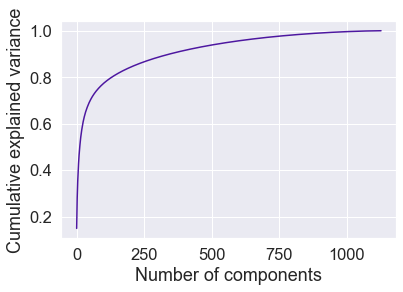

In [42]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(pca_data[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp,
                      index=pca_data.index, columns=pca_data.columns
                     )

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='#4D17A0')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [43]:
pca_75 = PCA(.80)
pca_75_df = pca_75.fit_transform(pca_data)
print(round(pca_75.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_75.n_components_,
      "components.")

80.0 % of variance explained by 131 components.


The cummulative explained variance shows an initially steep then gradual curve and not the sharp elbow we were expecting. This could be a result of the genomes already having been chosen as the principle components of movies. However we can see that 80% of the variance in the movie dataset is explained by 131 components. We should use only these components for computatonal efficiency in a content based model

In [44]:
pca_75_df = pd.DataFrame(pca_75_df, index = pca_data.index)
pca_75_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.796514,2.212839,-2.489444,1.624747,0.984763,1.168046,-0.203300,1.659382,-0.675962,-1.251265,-0.243100,1.458491,0.015197,-0.105688,0.425797,-0.912528,-0.355820,0.061083,...,-0.231842,0.003821,-0.240198,0.011903,-0.108367,-0.012805,0.070784,-0.095150,-0.166531,0.023522,0.124865,0.091553,-0.014734,-0.082235,0.029796,-0.077556,-0.072878,-0.094931
2,-1.541922,1.597864,-1.113613,1.302526,-0.196336,0.191809,-0.026161,1.208987,-0.369388,-0.483199,-0.226106,0.961881,-0.430214,-0.317001,-0.010892,0.299261,0.480117,-0.256093,...,-0.196130,-0.029274,0.129477,-0.080385,0.130292,0.078674,-0.034200,-0.104279,0.026369,-0.088038,0.113610,-0.050569,-0.015265,0.067904,0.026488,0.013665,0.079228,-0.130822
3,-1.506092,-0.010220,-0.605981,-0.316252,0.330972,0.334078,0.048253,0.010072,-0.042318,0.040345,0.191281,-0.182988,0.521585,-0.003704,-0.114366,-0.146336,-0.050823,0.019156,...,0.015790,-0.087111,-0.047043,0.147395,0.119151,-0.023542,-0.020572,0.151601,0.060794,-0.101178,0.033077,0.073228,-0.010904,-0.094919,0.019864,0.004834,0.059739,0.035608
4,-1.293604,-0.775662,-0.926582,-0.384600,0.103713,-0.345682,0.683775,0.218370,-0.159426,0.639183,0.406253,0.030442,-0.023683,-0.391013,0.194688,-0.379045,0.480997,0.083958,...,-0.036413,0.000460,0.121817,0.058174,-0.007047,0.057493,0.031200,0.016132,-0.036119,-0.145511,0.102927,-0.103027,0.005975,0.053953,0.044405,-0.202070,-0.158430,0.007054
5,-1.694557,-0.185986,-1.204239,-0.149549,0.470713,0.053199,0.385026,0.302557,-0.133082,-0.083749,0.364581,0.121228,0.940859,-0.199978,0.237478,-0.157197,-0.015649,-0.142857,...,-0.014334,-0.049426,-0.023443,-0.025480,0.180352,-0.231177,-0.075608,0.112447,0.016023,0.069098,-0.017486,0.005937,0.127657,-0.019529,-0.327449,-0.137680,-0.053703,0.065995


### Cluster Analysis

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data analysis, and a common technique for statistical data analysis, used in many fields, including pattern recognition, image analysis, information retrieval, bioinformatics, data compression, computer graphics and machine learning.

In [45]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='cluster_label'):
    """
    Manually implements the WCSS.
    """
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [46]:
# let's try everything between 2 and 18 clusters where 18 is the number of genres
n_clusters = np.arange(2, 19)

# store errors for each value of k
errors = []

# for i between 2 and 19
for k in n_clusters:
    print(f'training model with {k} clusters')
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(pca_75_df)
    
    # measure BCSS
    print(f'evaluating model with {k} clusters')
    y_preds = km.predict(pca_75_df)
    pca_75_df = pd.DataFrame(pca_75_df)
    pca_75_df['cluster_label'] = y_preds
    errors.append(within_cluster_variation(pca_75_df, 'cluster_label'))
    print(errors[-1])

training model with 2 clusters
evaluating model with 2 clusters
167610.09951547845
training model with 3 clusters
evaluating model with 3 clusters
159202.04716452217
training model with 4 clusters
evaluating model with 4 clusters
153979.41324329143
training model with 5 clusters
evaluating model with 5 clusters
149074.88861234672
training model with 6 clusters
evaluating model with 6 clusters
145054.80661973805
training model with 7 clusters
evaluating model with 7 clusters
141701.33766919663
training model with 8 clusters
evaluating model with 8 clusters
139251.25169642275
training model with 9 clusters
evaluating model with 9 clusters
137033.0260749196
training model with 10 clusters
evaluating model with 10 clusters
135148.42670872988
training model with 11 clusters
evaluating model with 11 clusters
132591.0326160025
training model with 12 clusters
evaluating model with 12 clusters
130792.51569023248
training model with 13 clusters
evaluating model with 13 clusters
129498.1890617720

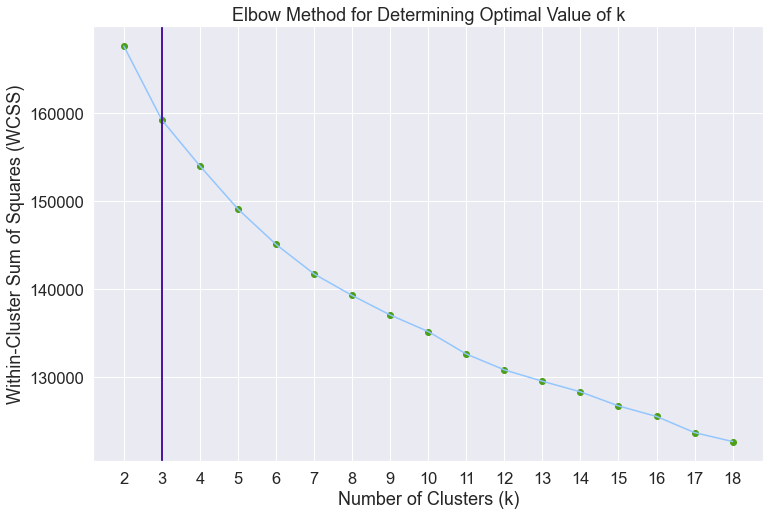

In [47]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors, color="#4DA017")
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.axvline(x=3, color='#4D17A0', lw=2)
plt.show()

Using the elbow method is as simple as observing the plot of the within-cluster sum of squares (WCSS) for each number of clusters and deciding where the 'elbow' is. The elbow is loosely defined as the point at which the WCSS curve has its greatest decrease in slope. In other words, it is the point after which adding another cluster does not meaningfully decrease the WCSS.

In [48]:
K = 3
# Remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(pca_75_df)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(n_clusters=3, random_state=42)
done in 0.255s


In [49]:
# Obtain cluster memberships for each item in the data
y_preds = km.predict(pca_75_df)
pca_75_df['cluster_label'] = y_preds
centers = km.cluster_centers_

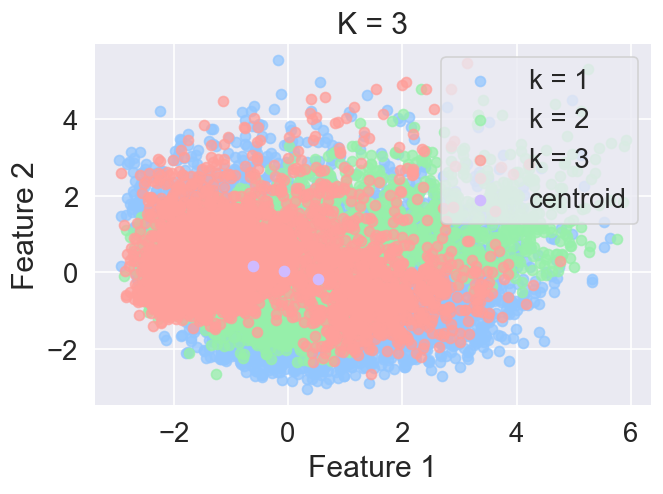

In [50]:
plt.figure(dpi=120)
for k in range(K):
    x1 = pca_75_df[pca_75_df['cluster_label'] == k][0]
    x2 = pca_75_df[pca_75_df['cluster_label'] == k][1]
    plt.scatter(x1, x2, label="k = "+str(k+1),alpha=0.75)
# Show cluster centroid locations    
plt.scatter(centers[:,0],centers[:,1],label="centroid")
plt.legend()
plt.title(f"K = {K}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Feature Selection

- To reduce computation time, we train and evaluate the following models on a 100k subset of the data. 
- Splitting the train data for modelling

In [83]:
# Load the 100k dataset
train_subset = train[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

<a id="seven"></a>
## **7. Model Selection**
<a class="anchor" id="1.1"></a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section we will be training and selecting model. |

---

Model selection is the process of selecting one final machine learning model from among a collection of candidate machine learning models for a training dataset. Model selection is a process that can be applied both across different types of models

Model selection will be based on content based and collaborative based filtering. In collaborative, we will selection one best performing models for kaggle submission and streamlit pickle. The most performing model will be based on the one with the lowest rmse value.

### Content-based Filtering  
Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. In the following section, the model uses genres as keywords to recommend similar movies based on input from a user. The model was not used to predict ratings for the testing data, as it is too computationally expensive.

In [55]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(4000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [56]:
movies_df = movies.dropna()
movie_list = ["I'll Do Anything (1994)",'Beverly Hillbillies, The (1993)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

['Four Rooms (1995)',
 'Ace Ventura: When Nature Calls (1995)',
 'Mr. Wrong (1996)',
 'Happy Gilmore (1996)',
 'Billy Madison (1995)',
 'Bye Bye, Love (1995)',
 'Denise Calls Up (1995)',
 'Theodore Rex (1995)',
 'Sgt. Bilko (1996)',
 'Superweib, Das (1996)']

### Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user 

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

\begin{align}
RMSE & = \sqrt{MSE} \\
     & = \sqrt{\frac{1}{N}\sum^{N} (\hat{y_i} - y_i)^{2}}
\end{align}

Where $y_i$ are the actual target values for a dataset with $N$ datapoints, and $\hat{y_i}$ represent our corresponding predictions. RMSE is a more intuitive metric to use than MSE because it is in the same units as the underlying variable being predicted.

#### SVD

The Singular Value Decomposition algorithm is a matrix factorization technique which reduces the number of features of a dataset. In the matrix structure, each row represents a user and each column represents a movie. The matrix elements are ratings that are given to movies by users.

#### NormalPredictor  
The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

#### BaselineOnly  
The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

#### NMF  
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

#### SlopeOne  
The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem. 

#### CoClustering  
The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

**Now we going to train and test the above explained model into our feature selected data**

In [52]:
bsl_options = {'method': 'sgd','n_epochs': 40}
baseline_model = BaselineOnly(bsl_options=bsl_options)

In [53]:
model = [SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42), NormalPredictor(), baseline_model, NMF(),  SlopeOne(),\
         CoClustering(random_state=42)]


In [54]:
for i in range(0, len(model)):
    #Creating a pipeline for the model names
    model_test = model[i]
    
    #Fitting the models to train data
    model_test.fit(trainset)  
    
    #Initiating a predict for the models
    predictions = model_test.test(testset)
    
    #Prints the name of the model
    print(model[i])
    
    #prints out the mean error of the model
    print(accuracy.mae(predictions))
    
    #Prints out the root mean error report of the model
    print(accuracy.rmse(predictions))

    
    print('--------------------------------------------------------')

MAE:  0.7229
0.722929736878665
RMSE: 0.9444
0.9443969941823529
--------------------------------------------------------
MAE:  1.0898
1.0898210324795783
RMSE: 1.3692
1.369162161743754
--------------------------------------------------------
Estimating biases using sgd...
MAE:  0.7166
0.7166203886992529
RMSE: 0.9380
0.9380344067661092
--------------------------------------------------------
MAE:  0.9048
0.9048191183852845
RMSE: 1.1389
1.1388526267766241
--------------------------------------------------------
MAE:  0.8121
0.812118048926487
RMSE: 1.0492
1.0492095089516633
--------------------------------------------------------
MAE:  0.8653
0.8653236308772715
RMSE: 1.1151
1.1150640709432786
--------------------------------------------------------


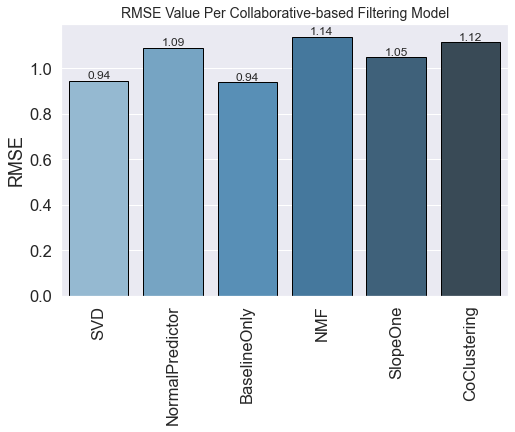

In [88]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [0.9444,1.0898,0.9380,1.1389,1.0492,1.1151]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='Blues_d',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

The best two performing model with a lower rmse values and svd with 0.9444 and BaslineOnly with 0.9380, the rest of the models would not be useful for us going forward, let us now cross validate both model to see if we can not be able to optimise the rmse score we have,


### Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfitting and selection bias. We used the K-fold technique to perform cross validation on our two best perfoming models, i.e. **SVD** and **BaselineOnly**.

In [57]:
model_best = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
val_ = cross_validate(model_best, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9286  0.9326  0.9451  0.9422  0.9368  0.9371  0.0060  
Fit time          12.02   12.00   12.07   12.42   14.12   12.52   0.81    
Test time         0.10    0.10    0.10    0.10    0.10    0.10    0.00    


The best performing k fold for the svd model is at k = 1 with a rmse score of 0.9286 

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
baseline = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
validate_accuracy= cross_validate(baseline, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9270  0.9231  0.9391  0.9413  0.9331  0.9327  0.0069  
Fit time          1.04    0.94    0.96    1.00    1.00    0.99    0.03    
Test time         0.07    0.22    0.07    0.07    0.07    0.10    0.06    


The best performing k fold for the BaselineOnlu model is at k= 2 with rmse of 0.9231

<span style='color:green'>With the two cross validation results, we will try hyperparameter tunning to optimise our results. In this case, we will only be moving forward with the svd model as it is easier to hyper tune it with the limited resources we using.</span>

In [65]:
# Create and add metrics to Perfermance Dataframe
#performance_df = pd.DataFrame()
#ssvd_0 = {'model': 'BaselineOnly', 'Cross_Validation': validate_accuracy}
#performance_df = performance_df.append([ssvd_0], ignore_index=True)
#display(performance_df)

# Log the parameters and results
#experiment.log_metrics(ssvd_0)
#experiment.set_code()


,model,Cross_Validation
0,BaselineOnly,"{'test_rmse': [0.9269977980865457, 0.923140489..."


COMET WARNING: Cannot safely convert {'test_rmse': array([0.9269978 , 0.92314049, 0.93906466, 0.94125216, 0.93307241]), 'fit_time': (1.0379486083984375, 0.9381916522979736, 0.9582157135009766, 0.9992568492889404, 0.9993152618408203), 'test_time': (0.07001566886901855, 0.21904945373535156, 0.07201623916625977, 0.06801533699035645, 0.06939411163330078)} object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET WARNING: Converting metric value ''BaselineOnly'' into a string using str(), resulting string might be invalid


<a id="eight"></a>
# **8. Model Evaluation**


---
    
| ⚡ Description:  Model Selection ⚡ |
| :--------------------------- |
| In this section will section we will be doing model evaluation the notebook.
---

The SVD model makes like easier when hyperparameter tuning, here will be be using the svd model

In [36]:
# Load the 100k dataset
train_subset = train[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Hyperparameter Tuning 

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. **SVD**).

In [61]:
param_grid = {'n_epochs':[40], 
              'n_factors':[500], 
              'init_std_dev':[0.005], 
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

***Best score:***
0.9305648774486469
***Best parameters:***
{'n_epochs': 40, 'n_factors': 500, 'init_std_dev': 0.01, 'random_state': 42}


In [62]:
svd_test = SVD(n_epochs = 40, n_factors = 500, init_std_dev = 0.005, random_state = 42, verbose=True)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9368


## Conclusion

The EDA insights and model evaluation will be useful in assisting stakeholders interested in movie recommender system, to  have a better view and understanding of the data. Results can be improved by adjusting parameters  and employing better preprocessing techniques. We intend to continue our research into developing and training models that produce the best results. 

The the model svd produced an rmse value of 0.78552 on Kaggle by the help of hyperparameter tunning, if given enough budget to invest more on the operating system, we believe we would have achieved better scores with the help of hyperparameter tunning.


Overall there are 2 approaches to rolling out the recommendation engine, we do so with the entire user base or we do so in stages, first with a representative sample of users, gauge the success of the engine, then roll it out to the entire user base.

Both approaches have consequences, the former: if things go wrong, the entire user base was exposed, and this will result in in a decrease in both revenues and brand affinity among users. The latter: happening in stages will incur more cost up front, costs which will have to weighed against potential future gains.

At this point in the phase of the project, our job as team CW6 is done, it is now up to management to consider the recommendations we have made, and chart the course for the next phase of taking the project to production.

<a id="nine"></a>
# **9. References**


---
    
| ⚡ Description:  Model Selection ⚡ |
| :--------------------------- |
| In this section will section we will be referencing recourses used.
---

1. BOOKS.
    
    - https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
    - Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems
    - Hands-On Unsupervised Learning Using Python: How to Build Applied Machine Learning Solutions from Unlabeled Data ~1st Edition~
    
2. Links.
    - Ajitsaria, A. (n.d.). Build a Recommendation Engine With Collaborative Filtering: https://realpython.com/build-recommendation-engine-collaborative-filtering
    - Recommender Systems: Content-based Filtering: http://recommender-systems.org/content-based-filtering/

In [85]:

# Create and add metrics to Perfermance Dataframe
'''experiment = Experiment(
    api_key="9PHva3TLb6iKcFaLO30pADfXK",
    project_name="movie-reccomender-edsa",
    workspace="caiphus24",
)

performance_df = pd.DataFrame()
ssvd_ = {'model': 'SVD', 'RMSE': svd_rmse}
performance_df = performance_df.append([ssvd_], ignore_index=True)
display(performance_df)

# Log the parameters and results
experiment.log_metrics(ssvd_)
experiment.set_code()
experiment.end'''

'experiment = Experiment(\n    api_key="9PHva3TLb6iKcFaLO30pADfXK",\n    project_name="movie-reccomender-edsa",\n    workspace="caiphus24",\n)\n\nperformance_df = pd.DataFrame()\nssvd_ = {\'model\': \'SVD\', \'RMSE\': svd_rmse}\nperformance_df = performance_df.append([ssvd_], ignore_index=True)\ndisplay(performance_df)\n\n# Log the parameters and results\nexperiment.log_metrics(ssvd_)\nexperiment.set_code()\nexperiment.end'

# Kaggle Submission

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train['rating'].min(), train['rating'].max()))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = svd = SVD(n_epochs = 60, n_factors = 800, init_std_dev = 0.005, random_state = 42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test['Id'] = test['userId'].map(str) +'_'+ test['movieId'].map(str)
results = pd.DataFrame({"Id":test['Id'],"rating": predictions})
results.to_csv("Team_CW6_submission.csv", index=False)